**Hardware Accelerator: L4 GPU**



# Libraries and imports

In [ ]:
from google.colab import drive
import os
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import glob
import cv2
import numpy as np
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
!pip install keras-tuner
import keras_tuner as kt
import time
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.0 MB/s eta 0:00:00


# Data Preparation

**Import dataset from google drive**

dataset in google drive is a zip folder. Here, the folder is unzipped and loaded into collab.

In [ ]:
drive.mount('/content/drive')

zip_file = '/content/drive/MyDrive/TomatoPlantVillage.zip'
extracted_file = '/content/PlantVillage'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_file)

os.listdir(extracted_file)
work_folder = '/content/PlantVillage/TomatoPlantVillage'
os.listdir(work_folder)

Mounted at /content/drive


['Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Early_blight',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Target_Spot',
 'Tomato_Late_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Bacterial_spot']

**Create training, validation, and test sets directories**

In [ ]:
#destinations
split_dataset = "TomatoPlantDataset/"
train_path = os.path.join(split_dataset, "training_data")
val_path = os.path.join(split_dataset, "validation_data")
test_path = os.path.join(split_dataset, "testing_data")

# makes seperate directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

**Data split**

Training 70%
Validation 15%
Testing 15%

In [ ]:
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# function to split data
def datasplit(work_folder, train_path, val_path, test_path):

    # gets class names
    class_names = os.listdir(work_folder)
    for cls in class_names:
        class_dir = os.path.join(work_folder, cls)
        images = os.listdir(class_dir)

        # splits dataset
        train_data, test_data = train_test_split(images, test_size=test_ratio, random_state=42)
        train_val, val_data = train_test_split(train_data, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

        # copies images to dedicated directories
        for img in train_val:
            shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, cls))
        for img in val_data:
            shutil.copy(os.path.join(class_dir, img), os.path.join(val_path, cls))
        for img in test_data:
            shutil.copy(os.path.join(class_dir, img), os.path.join(test_path, cls))

# create subdirectories for each class in train, val, test directories
for cls in os.listdir(work_folder):
    os.makedirs(os.path.join(train_path, cls), exist_ok=True)
    os.makedirs(os.path.join(val_path, cls), exist_ok=True)
    os.makedirs(os.path.join(test_path, cls), exist_ok=True)

# data split
datasplit(work_folder, train_path, val_path, test_path)

**Check data distribution in destination folders**

In [ ]:
def calculate_and_print_splits(train_dir, val_dir, test_dir):
    total_train = sum([len(files) for _, _, files in os.walk(train_dir)])
    total_val = sum([len(files) for _, _, files in os.walk(val_dir)])
    total_test = sum([len(files) for _, _, files in os.walk(test_dir)])

    total_files = total_train + total_val + total_test

    print(f"Total Files: {total_files}")
    print(f"Training Files: {total_train} ({(total_train / total_files) * 100:.2f}%)")
    print(f"Validation Files: {total_val} ({(total_val / total_files) * 100:.2f}%)")
    print(f"Testing Files: {total_test} ({(total_test / total_files) * 100:.2f}%)")

calculate_and_print_splits(train_path, val_path, test_path)

Total Files: 16012
Training Files: 11201 (69.95%)
Validation Files: 2405 (15.02%)
Testing Files: 2406 (15.03%)


In [ ]:
folder_path = 'data/testdata'
zip_path = 'testdata.zip'
shutil.make_archive('testdata', 'zip', folder_path)

# Data augmentation and prepare training and validation pipelines

In [ ]:
training_dir = '/content/TomatoPlantDataset/training_data'
validation_dir = '/content/TomatoPlantDataset/validation_data'
testing_dir = '/content/TomatoPlantDataset/testing_data'

**Download the test data beforehand for testing purpose!**

In [ ]:
test_zip = '/content/testdata.zip'
shutil.make_archive('testdata', 'zip', testing_dir)

files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Augmentation**

In [ ]:
# https://github.com/amitjha11/Plant-Disease-Detection-Using-VGG16/blob/master/plant-disease-detection-using-vgg16.ipynb

SIZE = 224  # in pixels
batch_size = 128

# data augmentation for training data
train_datagenerator = ImageDataGenerator(rescale=1./255,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          fill_mode='nearest')

# normalization for validation and test data
val_datagenerator = ImageDataGenerator(rescale=1.0 / 255)
test_datagenerator = ImageDataGenerator(rescale=1./255)

# generators
train_gen = train_datagenerator.flow_from_directory(training_dir, target_size=(SIZE, SIZE), batch_size=batch_size, class_mode='categorical', shuffle=True)
val_gen = val_datagenerator.flow_from_directory(validation_dir, target_size=(SIZE, SIZE), batch_size=batch_size, class_mode='categorical', shuffle=False)
test_gen = test_datagenerator.flow_from_directory(testing_dir, target_size=(SIZE, SIZE), batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 11201 images belonging to 10 classes.
Found 2405 images belonging to 10 classes.
Found 2405 images belonging to 10 classes.


In [ ]:
train_samples = train_gen.samples
val_samples = val_gen.samples

print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")

Training samples: 11201
Validation samples: 2405


**Extract Numerical classes from Categorical classes**

for confuson matrix

In [ ]:
class_names = train_gen.class_indices
class_keys = list(class_names.keys())

print(class_names)
print(class_keys)

{'Tomato_Bacterial_spot': 0, 'Tomato_Early_blight': 1, 'Tomato_Late_blight': 2, 'Tomato_Leaf_Mold': 3, 'Tomato_Septoria_leaf_spot': 4, 'Tomato_Spider_mites_Two_spotted_spider_mite': 5, 'Tomato__Target_Spot': 6, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 7, 'Tomato__Tomato_mosaic_virus': 8, 'Tomato_healthy': 9}
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# **Class Oversampling**

In [ ]:
# https://stackoverflow.com/questions/69783897/compute-class-weight-function-issue-in-sklearn-library-when-used-in-keras-cl
# https://scikit-learn.org/dev/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

compute_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = dict(zip(np.unique(train_gen.classes), compute_weights))
class_weights

{0: 0.7527553763440861,
 1: 1.600142857142857,
 2: 0.8390262172284644,
 3: 1.681831831831832,
 4: 0.9040355125100887,
 5: 0.955716723549488,
 6: 1.1406313645621182,
 7: 0.4989309576837416,
 8: 4.291570881226054,
 9: 1.0063791554357593}

# Feature Extraction

**Set up VGG16 as feature extractor**

In [ ]:
# https://stackoverflow.com/questions/65851403/vgg16-with-other-input-shape-and-imagenet-weights
# https://www.youtube.com/watch?v=Fxy6WTnUIww

# VGG16 model with pre-trained weights and without fully connected layer
vgg16_feature_extractor = VGG16(include_top=False,
                   input_shape=(SIZE, SIZE, 3),
                   weights='imagenet')

# loaded layers as non-trainable, freezing
for layer in vgg16_feature_extractor.layers:
	  layer.trainable = False  # freeze VGG16 layers initially

vgg16_feature_extractor.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# https://towardsdatascience.com/fine-tuning-pre-trained-model-vgg-16-1277268c537f

for i, layer in enumerate(vgg16_feature_extractor.layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


# Hyperparameter Tuning

**Hyperparameter tuning Function**

In [ ]:
# https://www.digitalocean.com/community/tutorials/hyperparameter-optimization-with-keras-tuner
# hp.Int() https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
# https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
# https://www.kaggle.com/code/mukeshmanral/using-kerastuner-dropout

def custom_hyp_tune(hp):

    custom_hp = keras.models.Sequential()
    custom_hp.add(vgg16_feature_extractor)
    custom_hp.add(Flatten())
    custom_hp.add(Dense(hp.Int('dense_units', min_value=8, max_value=100, step=20),
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.01)))
    custom_hp.add(Dropout(hp.Choice(name='dropout', values=[0.25, 0.5])))
    custom_hp.add(Dense(10, activation='softmax'))

    custom_hp.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate',
                                                                              min_value=1e-5, max_value=1e-2,
                                                                              sampling='log')),
                    loss='categorical_crossentropy', metrics=['accuracy'])

    return custom_hp


.search() is to perform hyperparameter tuning using Keras Tuner to find the best set of hyperparameters.

performs a randomized search over the defined hyperparameter space, to identify the model configuration that provides the best validation accuracy.

**Optimization with Random Search**

In [ ]:
# https://medium.com/@piyushkashyap045/mastering-hyperparameter-tuning-for-neural-networks-with-keras-tuner-c0b64d549188#:~:text=Keras%20Tuner%20is%20a%20library,tuning%20for%20deep%20learning%20models.

# hyperparameters
k_tuner = kt.RandomSearch(
    custom_hyp_tune,
    objective='val_accuracy',
    max_trials=5,
    seed=42,
    directory='keras_tuning_directory',
    project_name='hyperparameter_tuning'
)

early_stop = EarlyStopping(monitor='val_loss',
                               patience=2,
                               restore_best_weights=True)

cp = ModelCheckpoint(filepath='custom_best_hyperparameter_model.keras', verbose=1, save_best_only=True)

# random Search
start = time.time()
k_tuner.search(train_gen,
               epochs=5,
               steps_per_epoch = train_samples // batch_size,
               validation_data=val_gen,
               validation_steps = val_samples // batch_size,
               class_weight = class_weights,
               verbose=1,
               callbacks=[cp, early_stop])
end = time.time()
print(f"Search time: {end - start} seconds")

Trial 5 Complete [00h 06m 25s]
val_accuracy: 0.3103298544883728

Best val_accuracy So Far: 0.9702970385551453
Total elapsed time: 00h 33m 13s
Search time: 1993.128294467926 seconds


In [ ]:
best_hyperparameter = k_tuner.get_best_hyperparameters(1)[0]
best_hyperparameter.values

{'dense_units': 28, 'dropout': 0.5, 'learning_rate': 0.0007102715674987189}

In [ ]:
# to force delete a folder

import tensorflow as tf
!rm -rf /content/keras_tuning_directory

# Model Training, validation, Testing

**Function for experiments**

In [ ]:
def custom_model_experiments(neurons, dropout, learning_rate):

    custom_model = keras.models.Sequential()
    custom_model.add(vgg16_feature_extractor)
    custom_model.add(Flatten())
    custom_model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    custom_model.add(Dropout(dropout))
    custom_model.add(Dense(10, activation='softmax'))

    custom_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='categorical_crossentropy', metrics=['accuracy'])

    return custom_model

**Experimental Training**

In [ ]:
def train_and_evaluate(neurons, dropout, learning_rate, trial_id=1):

    model = custom_model_experiments(neurons, dropout, learning_rate)

    early_stop = EarlyStopping(monitor='val_loss',
                               patience=2,
                               restore_best_weights=True,
                               verbose=1)

    print(f"for neurons={neurons}, dropout={dropout}, learning_rate={learning_rate}:")

    start = time.time()
    best_model_history = model.fit(
        train_gen,
        steps_per_epoch = train_samples // batch_size,
        validation_data = val_gen,
        epochs = 5,
        validation_steps = val_samples // batch_size,
        class_weight = class_weights,
        callbacks=[early_stop],
        verbose=1
        )
    end = time.time()
    print(f"Training time: {end - start} seconds")

    val_accuracy = max(best_model_history.history['val_accuracy'])  # among 5 epoch
    print(f"Highest Validation Accuracy: {val_accuracy}")

    test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
    print(f"Test Accuracy: {test_accuracy}")

    model_filename = f'Experimental_trial_{trial_id}_model.h5'
    model.save(model_filename)
    print(f"Model for experimental trial {trial_id} saved as {model_filename}")

    return val_accuracy, test_accuracy, model_filename


# Tests and Experiments

With different hyperparameter combinations

**Test 1**

Trial 1-6

In [ ]:
results = []

results.append(train_and_evaluate(28, 0.5, 0.0007, trial_id=1))
results.append(train_and_evaluate(64, 0.5, 0.0007, trial_id=2))
results.append(train_and_evaluate(128, 0.5, 0.0007, trial_id=3))
results.append(train_and_evaluate(256, 0.5, 0.0007, trial_id=4))
results.append(train_and_evaluate(512, 0.5, 0.0007, trial_id=5))
results.append(train_and_evaluate(1024, 0.5, 0.0007, trial_id=6))

for result in results:
    val_accuracy, test_accuracy, model_filename = result
    print(f"Trial model {model_filename}: Validation Accuracy = {val_accuracy}, Test Accuracy = {test_accuracy}")

for neurons=28, dropout=0.5, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.0704 - loss: 2.5908 - val_accuracy: 0.2947 - val_loss: 2.2802
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2422 - loss: 2.3373 - val_accuracy: 0.0000e+00 - val_loss: 1.8372
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.2339 - loss: 2.2644 - val_accuracy: 0.2431 - val_loss: 2.1995
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2344 - loss: 2.2078 - val_accuracy: 1.0000 - val_loss: 1.4122
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2399 - loss: 2.1941 - val_accuracy: 0.2622 - val_loss: 2.1733
Restoring model weights from the end of the best epoch: 4.
Training time: 380.171267747879 seconds
Highest Validation Accuracy: 1.0
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.0721 - loss: 2.2865


Test Accuracy: 0.2801330089569092
Model for experimental trial 1 saved as Experimental_trial_1_model.h5
for neurons=64, dropout=0.5, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.1538 - loss: 3.0652 - val_accuracy: 0.3472 - val_loss: 2.0147
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2578 - loss: 2.4039 - val_accuracy: 0.9109 - val_loss: 1.3787
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2972 - loss: 2.1960 - val_accuracy: 0.4848 - val_loss: 1.7708
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3906 - loss: 1.9488 - val_accuracy: 1.0000 - val_loss: 0.9140
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.3074 - loss: 2.0364 - val_accuracy: 0.5820 - val_loss: 1.6384
Restoring model weights from the end of the best epoch: 4.
Training time: 381.6961510181427 seconds
Highest Validation Accuracy: 1.0
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.3976 - loss: 1.9472


Test Accuracy: 0.46550291776657104
Model for experimental trial 2 saved as Experimental_trial_2_model.h5
for neurons=128, dropout=0.5, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2320 - loss: 3.6344 - val_accuracy: 0.6793 - val_loss: 1.7203
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3750 - loss: 2.0137 - val_accuracy: 0.7624 - val_loss: 1.6760
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4024 - loss: 2.0020 - val_accuracy: 0.7305 - val_loss: 1.4015
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4141 - loss: 1.8538 - val_accuracy: 0.8911 - val_loss: 1.0881
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4335 - loss: 1.7940 - val_accuracy: 0.7478 - val_loss: 1.2474
Restoring model weights from the end of the best epoch: 4.
Training time: 382.1507019996643 seconds
Highest Validation Accuracy: 0.8910890817642212
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - accuracy: 0.7166 - loss

Test Accuracy: 0.7277639508247375
Model for experimental trial 3 saved as Experimental_trial_3_model.h5
for neurons=256, dropout=0.5, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2768 - loss: 4.8311 - val_accuracy: 0.7096 - val_loss: 1.6759
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4922 - loss: 2.1302 - val_accuracy: 0.4950 - val_loss: 1.7043
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5259 - loss: 1.9458 - val_accuracy: 0.7318 - val_loss: 1.3022
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 1.5570 - val_accuracy: 0.9307 - val_loss: 0.8949
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5801 - loss: 1.6364 - val_accuracy: 0.7370 - val_loss: 1.1693
Restoring model weights from the end of the best epoch: 4.
Training time: 382.58489966392517 seconds
Highest Validation Accuracy: 0.9306930899620056
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.7227 - loss

Test Accuracy: 0.727348268032074
Model for experimental trial 4 saved as Experimental_trial_4_model.h5
for neurons=512, dropout=0.5, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3049 - loss: 7.1340 - val_accuracy: 0.7248 - val_loss: 1.9062
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5391 - loss: 2.3140 - val_accuracy: 0.7228 - val_loss: 1.7733
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5787 - loss: 2.0363 - val_accuracy: 0.7561 - val_loss: 1.3883
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5547 - loss: 1.6952 - val_accuracy: 0.9010 - val_loss: 0.9662
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6235 - loss: 1.6373 - val_accuracy: 0.7548 - val_loss: 1.1730
Restoring model weights from the end of the best epoch: 4.
Training time: 383.11161637306213 seconds
Highest Validation Accuracy: 0.9009901285171509
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - accuracy: 0.7262 - loss:

Test Accuracy: 0.7614297866821289
Model for experimental trial 5 saved as Experimental_trial_5_model.h5
for neurons=1024, dropout=0.5, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3115 - loss: 11.7413 - val_accuracy: 0.7578 - val_loss: 2.2246
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6250 - loss: 2.5067 - val_accuracy: 0.9010 - val_loss: 1.8488
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6154 - loss: 2.3111 - val_accuracy: 0.7713 - val_loss: 1.4816
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6641 - loss: 1.6104 - val_accuracy: 0.7921 - val_loss: 1.3056
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6558 - loss: 1.7227 - val_accuracy: 0.7938 - val_loss: 1.1823
Restoring model weights from the end of the best epoch: 5.
Training time: 383.3356022834778 seconds
Highest Validation Accuracy: 0.9009901285171509
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - accuracy: 0.7833 - los

Test Accuracy: 0.7896924614906311
Model for experimental trial 6 saved as Experimental_trial_6_model.h5
Trial model Experimental_trial_1_model.h5: Validation Accuracy = 1.0, Test Accuracy = 0.2801330089569092
Trial model Experimental_trial_2_model.h5: Validation Accuracy = 1.0, Test Accuracy = 0.46550291776657104
Trial model Experimental_trial_3_model.h5: Validation Accuracy = 0.8910890817642212, Test Accuracy = 0.7277639508247375
Trial model Experimental_trial_4_model.h5: Validation Accuracy = 0.9306930899620056, Test Accuracy = 0.727348268032074
Trial model Experimental_trial_5_model.h5: Validation Accuracy = 0.9009901285171509, Test Accuracy = 0.7614297866821289
Trial model Experimental_trial_6_model.h5: Validation Accuracy = 0.9009901285171509, Test Accuracy = 0.7896924614906311


**Test 2**

Trial 7-12

In [ ]:
results2 = []

results2.append(train_and_evaluate(28, 0.25, 0.0007, trial_id=7))
results2.append(train_and_evaluate(64, 0.25, 0.0007, trial_id=8))
results2.append(train_and_evaluate(128, 0.25, 0.0007, trial_id=9))
results2.append(train_and_evaluate(256, 0.25, 0.0007, trial_id=10))
results2.append(train_and_evaluate(512, 0.25, 0.0007, trial_id=11))
results2.append(train_and_evaluate(1024, 0.25, 0.0007, trial_id=12))

for result in results2:
    val_accuracy, test_accuracy, model_filename = result
    print(f"Trial model {model_filename}: Validation Accuracy = {val_accuracy}, Test Accuracy = {test_accuracy}")

for neurons=28, dropout=0.25, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.1410 - loss: 2.5848 - val_accuracy: 0.2530 - val_loss: 2.0595
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1875 - loss: 2.1551 - val_accuracy: 0.0000e+00 - val_loss: 2.4446
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2309 - loss: 2.1935 - val_accuracy: 0.4240 - val_loss: 1.8956
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 2.1675 - val_accuracy: 0.0000e+00 - val_loss: 2.3558
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.3082 - loss: 2.0687 - val_accuracy: 0.4280 - val_loss: 1.8013
Restoring model weights from the end of the best epoch: 5.
Training time: 380.79856300354004 seconds
Highest Validation Accuracy: 0.4279513955116272
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.4867 - loss: 1.7321


Test Accuracy: 0.40856191515922546
Model for experimental trial 7 saved as Experimental_trial_7_model.h5
for neurons=64, dropout=0.25, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2760 - loss: 2.7283 - val_accuracy: 0.6332 - val_loss: 1.5382
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3672 - loss: 2.1859 - val_accuracy: 0.9109 - val_loss: 1.1357
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4749 - loss: 1.7588 - val_accuracy: 0.6923 - val_loss: 1.3075
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5078 - loss: 1.5191 - val_accuracy: 0.9802 - val_loss: 0.7590
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5118 - loss: 1.5991 - val_accuracy: 0.7318 - val_loss: 1.1942
Restoring model weights from the end of the best epoch: 4.
Training time: 380.366233587265 seconds
Highest Validation Accuracy: 0.9801980257034302
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.6774 - loss: 

Test Accuracy: 0.7019950151443481
Model for experimental trial 8 saved as Experimental_trial_8_model.h5
for neurons=128, dropout=0.25, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2535 - loss: 3.4177 - val_accuracy: 0.6871 - val_loss: 1.5392
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4375 - loss: 2.2804 - val_accuracy: 0.7327 - val_loss: 1.2967
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5159 - loss: 1.7351 - val_accuracy: 0.7600 - val_loss: 1.1631
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5625 - loss: 1.6660 - val_accuracy: 0.8119 - val_loss: 0.9840
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5782 - loss: 1.5258 - val_accuracy: 0.7726 - val_loss: 1.0960
Restoring model weights from the end of the best epoch: 4.
Training time: 380.6673586368561 seconds
Highest Validation Accuracy: 0.8118811845779419
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.7355 - loss:

Test Accuracy: 0.7485452890396118
Model for experimental trial 9 saved as Experimental_trial_9_model.h5
for neurons=256, dropout=0.25, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2840 - loss: 5.1223 - val_accuracy: 0.6710 - val_loss: 1.7222
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5625 - loss: 2.0017 - val_accuracy: 0.4059 - val_loss: 1.9180
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5710 - loss: 1.8545 - val_accuracy: 0.7209 - val_loss: 1.2683
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6328 - loss: 1.7106 - val_accuracy: 0.8713 - val_loss: 0.9231
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6493 - loss: 1.4691 - val_accuracy: 0.8021 - val_loss: 1.0247
Restoring model weights from the end of the best epoch: 4.
Training time: 382.0353925228119 seconds
Highest Validation Accuracy: 0.8712871074676514
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.7000 - loss:

Test Accuracy: 0.729010820388794
Model for experimental trial 10 saved as Experimental_trial_10_model.h5
for neurons=512, dropout=0.25, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3405 - loss: 7.4491 - val_accuracy: 0.7760 - val_loss: 1.7634
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6719 - loss: 2.1908 - val_accuracy: 0.8515 - val_loss: 1.6803
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6797 - loss: 1.8475 - val_accuracy: 0.7873 - val_loss: 1.2617
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 1.6049 - val_accuracy: 0.4950 - val_loss: 1.6008
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7122 - loss: 1.4282 - val_accuracy: 0.7435 - val_loss: 1.1998
Restoring model weights from the end of the best epoch: 5.
Training time: 381.3581292629242 seconds
Highest Validation Accuracy: 0.8514851331710815
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - accuracy: 0.7325 - loss

Test Accuracy: 0.7489609122276306
Model for experimental trial 11 saved as Experimental_trial_11_model.h5
for neurons=1024, dropout=0.25, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.3152 - loss: 12.2689 - val_accuracy: 0.7591 - val_loss: 2.2479
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6953 - loss: 2.5805 - val_accuracy: 0.8020 - val_loss: 2.0619
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6783 - loss: 2.2087 - val_accuracy: 0.7812 - val_loss: 1.4277
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7422 - loss: 1.6831 - val_accuracy: 0.9208 - val_loss: 1.1293
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7263 - loss: 1.5242 - val_accuracy: 0.7878 - val_loss: 1.1683
Restoring model weights from the end of the best epoch: 4.
Training time: 381.5086307525635 seconds
Highest Validation Accuracy: 0.9207921028137207
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.7714 - l

Test Accuracy: 0.7776392102241516
Model for experimental trial 12 saved as Experimental_trial_12_model.h5
Trial model Experimental_trial_7_model.h5: Validation Accuracy = 0.4279513955116272, Test Accuracy = 0.40856191515922546
Trial model Experimental_trial_8_model.h5: Validation Accuracy = 0.9801980257034302, Test Accuracy = 0.7019950151443481
Trial model Experimental_trial_9_model.h5: Validation Accuracy = 0.8118811845779419, Test Accuracy = 0.7485452890396118
Trial model Experimental_trial_10_model.h5: Validation Accuracy = 0.8712871074676514, Test Accuracy = 0.729010820388794
Trial model Experimental_trial_11_model.h5: Validation Accuracy = 0.8514851331710815, Test Accuracy = 0.7489609122276306
Trial model Experimental_trial_12_model.h5: Validation Accuracy = 0.9207921028137207, Test Accuracy = 0.7776392102241516


**Test 3**

Trial 13-16

In [ ]:
results3 = []

results3.append(train_and_evaluate(1024, 0.5, 0.007, trial_id=13))
results3.append(train_and_evaluate(1024, 0.5, 0.07, trial_id=14))
results3.append(train_and_evaluate(1024, 0.5, 0.7, trial_id=15))
results3.append(train_and_evaluate(1024, 0.5, 0.00007, trial_id=16))

for result in results3:
    val_accuracy, test_accuracy, model_filename = result
    print(f"Trial model {model_filename}: Validation Accuracy = {val_accuracy}, Test Accuracy = {test_accuracy}")

for neurons=1024, dropout=0.5, learning_rate=0.007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.1643 - loss: 54.9001 - val_accuracy: 0.4457 - val_loss: 4.7925
Epoch 2/5
 1/87 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.3125 - loss: 4.9816

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3125 - loss: 4.9816 - val_accuracy: 0.8218 - val_loss: 4.4092
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.1765 - loss: 5.2793 - val_accuracy: 0.2895 - val_loss: 3.1452
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2422 - loss: 3.0731 - val_accuracy: 0.6535 - val_loss: 2.4120
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.1687 - loss: 3.2279 - val_accuracy: 0.2374 - val_loss: 3.3536
Restoring model weights from the end of the best epoch: 4.
Training time: 382.228844165802 seconds
Highest Validation Accuracy: 0.8217821717262268
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - accuracy: 0.3723 - loss: 3.0269


Test Accuracy: 0.28512054681777954
Model for experimental trial 13 saved as Experimental_trial_13_model.h5
for neurons=1024, dropout=0.5, learning_rate=0.07:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.1082 - loss: 1570.4445 - val_accuracy: 0.1246 - val_loss: 394.6497
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0859 - loss: 394.9807 - val_accuracy: 0.0000e+00 - val_loss: 387.0008
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.0999 - loss: 317.7382 - val_accuracy: 0.0243 - val_loss: 143.0954
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 142.9063 - val_accuracy: 0.0000e+00 - val_loss: 144.5469
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.1042 - loss: 142.4918 - val_accuracy: 0.1246 - val_loss: 37.7796
Restoring model weights from the end of the best epoch: 5.
Training time: 382.0255012512207 seconds
Highest Validation Accuracy: 0.1245659738779068
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 312m

Test Accuracy: 0.11928512156009674
Model for experimental trial 14 saved as Experimental_trial_14_model.h5
for neurons=1024, dropout=0.5, learning_rate=0.7:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.0975 - loss: 149278.0156 - val_accuracy: 0.0655 - val_loss: 18901.5859
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1094 - loss: 18901.4375 - val_accuracy: 0.0000e+00 - val_loss: 19003.1328
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.1104 - loss: 23323.6816 - val_accuracy: 0.0243 - val_loss: 5230.9409
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0391 - loss: 5231.1743 - val_accuracy: 0.0000e+00 - val_loss: 5031.2949
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.0846 - loss: 4251.3960 - val_accuracy: 0.1402 - val_loss: 5235.1318
Restoring model weights from the end of the best epoch: 4.
Training time: 380.8805606365204 seconds
Highest Validation Accuracy: 0.1401909738779068
19/19 ━━━━━━━━━━━━━━━━━

Test Accuracy: 0.06566916406154633
Model for experimental trial 15 saved as Experimental_trial_15_model.h5
for neurons=1024, dropout=0.5, learning_rate=7e-05:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.3349 - loss: 18.4961 - val_accuracy: 0.7361 - val_loss: 10.2214
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6641 - loss: 10.5242 - val_accuracy: 0.7327 - val_loss: 10.1760
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6530 - loss: 9.1298 - val_accuracy: 0.7908 - val_loss: 5.9817
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7109 - loss: 6.2355 - val_accuracy: 0.9010 - val_loss: 5.6641
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7235 - loss: 5.6402 - val_accuracy: 0.8134 - val_loss: 4.2408
Restoring model weights from the end of the best epoch: 5.
Training time: 381.1906566619873 seconds
Highest Validation Accuracy: 0.9009901285171509
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 312ms/step - accuracy: 0.8165 -

Test Accuracy: 0.8287614583969116
Model for experimental trial 16 saved as Experimental_trial_16_model.h5
Trial model Experimental_trial_13_model.h5: Validation Accuracy = 0.8217821717262268, Test Accuracy = 0.28512054681777954
Trial model Experimental_trial_14_model.h5: Validation Accuracy = 0.1245659738779068, Test Accuracy = 0.11928512156009674
Trial model Experimental_trial_15_model.h5: Validation Accuracy = 0.1401909738779068, Test Accuracy = 0.06566916406154633
Trial model Experimental_trial_16_model.h5: Validation Accuracy = 0.9009901285171509, Test Accuracy = 0.8287614583969116


**Test 4**

Trial 17 & 20

In [ ]:
results4 = []

results4.append(train_and_evaluate(1024, 0.25, 0.007, trial_id=17))
results4.append(train_and_evaluate(1024, 0.25, 0.07, trial_id=18))
results4.append(train_and_evaluate(1024, 0.25, 0.7, trial_id=19))
results4.append(train_and_evaluate(1024, 0.25, 0.00007, trial_id=20))


for result in results4:
    val_accuracy, test_accuracy, model_filename = result
    print(f"Trial model {model_filename}: Validation Accuracy = {val_accuracy}, Test Accuracy = {test_accuracy}")

for neurons=1024, dropout=0.25, learning_rate=0.007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2277 - loss: 53.5488 - val_accuracy: 0.4818 - val_loss: 5.3166
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3750 - loss: 5.8021 - val_accuracy: 0.1683 - val_loss: 5.7618
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2900 - loss: 5.4750 - val_accuracy: 0.2270 - val_loss: 3.7539
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2422 - loss: 3.8230 - val_accuracy: 0.9406 - val_loss: 2.4279
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.3881 - loss: 3.0962 - val_accuracy: 0.4622 - val_loss: 2.2266
Restoring model weights from the end of the best epoch: 5.
Training time: 380.8976819515228 seconds
Highest Validation Accuracy: 0.9405940771102905
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.4397 - loss: 2.2671


Test Accuracy: 0.46384039521217346
Model for experimental trial 17 saved as Experimental_trial_17_model.h5
for neurons=1024, dropout=0.25, learning_rate=0.07:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.1281 - loss: 1808.4634 - val_accuracy: 0.1385 - val_loss: 380.4477
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1250 - loss: 398.0475 - val_accuracy: 0.0000e+00 - val_loss: 267.9659
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.0831 - loss: 282.1883 - val_accuracy: 0.2092 - val_loss: 131.2555
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2188 - loss: 131.0828 - val_accuracy: 0.0000e+00 - val_loss: 127.8939
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.1639 - loss: 108.9008 - val_accuracy: 0.1246 - val_loss: 55.3186
Restoring model weights from the end of the best epoch: 5.
Training time: 381.18009305000305 seconds
Highest Validation Accuracy: 0.2092013955116272
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/

Test Accuracy: 0.11928512156009674
Model for experimental trial 18 saved as Experimental_trial_18_model.h5
for neurons=1024, dropout=0.25, learning_rate=0.7:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.1015 - loss: 149275.6875 - val_accuracy: 0.0677 - val_loss: 21943.3750
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1484 - loss: 21964.9277 - val_accuracy: 0.0000e+00 - val_loss: 22432.8320
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.1136 - loss: 23982.6406 - val_accuracy: 0.1306 - val_loss: 10276.5352
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1172 - loss: 10276.6846 - val_accuracy: 0.0000e+00 - val_loss: 9749.4990
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.0878 - loss: 5386.6929 - val_accuracy: 0.0243 - val_loss: 1432.5554
Restoring model weights from the end of the best epoch: 5.
Training time: 381.12884044647217 seconds
Highest Validation Accuracy: 0.1306423544883728
19/19 ━━━━━━━━━━━━━

Test Accuracy: 0.023275146260857582
Model for experimental trial 19 saved as Experimental_trial_19_model.h5
for neurons=1024, dropout=0.25, learning_rate=7e-05:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.3844 - loss: 18.2593 - val_accuracy: 0.7574 - val_loss: 9.9903
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7500 - loss: 10.0166 - val_accuracy: 0.7723 - val_loss: 9.9056
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7057 - loss: 8.7930 - val_accuracy: 0.8138 - val_loss: 5.7336
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7656 - loss: 5.7932 - val_accuracy: 0.9010 - val_loss: 5.4853
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7749 - loss: 5.3400 - val_accuracy: 0.8103 - val_loss: 4.0674
Restoring model weights from the end of the best epoch: 5.
Training time: 380.76172065734863 seconds
Highest Validation Accuracy: 0.9009901285171509
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.8163 

Test Accuracy: 0.8104737997055054
Model for experimental trial 20 saved as Experimental_trial_20_model.h5
Trial model Experimental_trial_17_model.h5: Validation Accuracy = 0.9405940771102905, Test Accuracy = 0.46384039521217346
Trial model Experimental_trial_18_model.h5: Validation Accuracy = 0.2092013955116272, Test Accuracy = 0.11928512156009674
Trial model Experimental_trial_19_model.h5: Validation Accuracy = 0.1306423544883728, Test Accuracy = 0.023275146260857582
Trial model Experimental_trial_20_model.h5: Validation Accuracy = 0.9009901285171509, Test Accuracy = 0.8104737997055054


**Test 5**

Trial 21-24

In [ ]:
results5 = []

results5.append(train_and_evaluate(2048, 0.5, 0.00007, trial_id=21))
results5.append(train_and_evaluate(2048, 0.25, 0.00007, trial_id=22))
results5.append(train_and_evaluate(2048, 0.5, 0.0007, trial_id=23))
results5.append(train_and_evaluate(2048, 0.25, 0.0007, trial_id=24))


for result in results5:
    val_accuracy, test_accuracy, model_filename = result
    print(f"Trial model {model_filename}: Validation Accuracy = {val_accuracy}, Test Accuracy = {test_accuracy}")

for neurons=2048, dropout=0.5, learning_rate=7e-05:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.3644 - loss: 33.2428 - val_accuracy: 0.7422 - val_loss: 17.6500
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6328 - loss: 18.0015 - val_accuracy: 0.7129 - val_loss: 17.5319
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6781 - loss: 15.2045 - val_accuracy: 0.7960 - val_loss: 9.4362
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6875 - loss: 9.7809 - val_accuracy: 0.8416 - val_loss: 9.2736
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7471 - loss: 8.5976 - val_accuracy: 0.8433 - val_loss: 6.1975
Restoring model weights from the end of the best epoch: 5.
Training time: 384.7934308052063 seconds
Highest Validation Accuracy: 0.8433159589767456
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 398ms/step - accuracy: 0.8299 - loss: 6.2093


Test Accuracy: 0.8370739817619324
Model for experimental trial 21 saved as Experimental_trial_21_model.h5
for neurons=2048, dropout=0.25, learning_rate=7e-05:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.4205 - loss: 32.8361 - val_accuracy: 0.7756 - val_loss: 16.9981
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6797 - loss: 17.3253 - val_accuracy: 0.8515 - val_loss: 16.6348
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7153 - loss: 14.4663 - val_accuracy: 0.8021 - val_loss: 8.8463
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7422 - loss: 8.9448 - val_accuracy: 0.7426 - val_loss: 8.7920
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7859 - loss: 7.9345 - val_accuracy: 0.8372 - val_loss: 5.7103
Restoring model weights from the end of the best epoch: 5.
Training time: 382.0698902606964 seconds
Highest Validation Accuracy: 0.8514851331710815
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.8066

Test Accuracy: 0.832086443901062
Model for experimental trial 22 saved as Experimental_trial_22_model.h5
for neurons=2048, dropout=0.5, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.3242 - loss: 19.1750 - val_accuracy: 0.7409 - val_loss: 2.7842
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6328 - loss: 3.0278 - val_accuracy: 0.6931 - val_loss: 2.8169
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6503 - loss: 2.6609 - val_accuracy: 0.8025 - val_loss: 1.6402
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 1.8661 - val_accuracy: 0.6733 - val_loss: 1.6826
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6550 - loss: 1.8723 - val_accuracy: 0.7947 - val_loss: 1.3457
Restoring model weights from the end of the best epoch: 5.
Training time: 381.16445326805115 seconds
Highest Validation Accuracy: 0.8025173544883728
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.7789 - lo

Test Accuracy: 0.7880299091339111
Model for experimental trial 23 saved as Experimental_trial_23_model.h5
for neurons=2048, dropout=0.25, learning_rate=0.0007:
Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3158 - loss: 21.1832 - val_accuracy: 0.7574 - val_loss: 3.1402
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6797 - loss: 3.2422 - val_accuracy: 0.7921 - val_loss: 2.9771
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6967 - loss: 2.8335 - val_accuracy: 0.7808 - val_loss: 1.7448
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7188 - loss: 2.0824 - val_accuracy: 0.7921 - val_loss: 1.7372
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7145 - loss: 1.8011 - val_accuracy: 0.7834 - val_loss: 1.3697
Restoring model weights from the end of the best epoch: 5.
Training time: 382.13445258140564 seconds
Highest Validation Accuracy: 0.7920792102813721
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.7154 -

Test Accuracy: 0.7888611555099487
Model for experimental trial 24 saved as Experimental_trial_24_model.h5
Trial model Experimental_trial_21_model.h5: Validation Accuracy = 0.8433159589767456, Test Accuracy = 0.8370739817619324
Trial model Experimental_trial_22_model.h5: Validation Accuracy = 0.8514851331710815, Test Accuracy = 0.832086443901062
Trial model Experimental_trial_23_model.h5: Validation Accuracy = 0.8025173544883728, Test Accuracy = 0.7880299091339111
Trial model Experimental_trial_24_model.h5: Validation Accuracy = 0.7920792102813721, Test Accuracy = 0.7888611555099487


**Test 6**

Trial 25

In [ ]:
results6 = []

results6.append(train_and_evaluate(1024, 0, 0.00007, trial_id=25))

for result in results6:
    val_accuracy, test_accuracy, model_filename = result
    print(f"Trial model {model_filename}: Validation Accuracy = {val_accuracy}, Test Accuracy = {test_accuracy}")

for neurons=1024, dropout=0, learning_rate=7e-05:
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.4361 - loss: 18.1119 - val_accuracy: 0.7852 - val_loss: 9.8039
Epoch 2/5
 1/87 ━━━━━━━━━━━━━━━━━━━━ 25s 295ms/step - accuracy: 0.7344 - loss: 9.9768

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.7344 - loss: 9.9768 - val_accuracy: 0.9208 - val_loss: 9.3909
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7542 - loss: 8.5206 - val_accuracy: 0.7826 - val_loss: 5.5997
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7109 - loss: 5.7131 - val_accuracy: 0.8317 - val_loss: 5.3007
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7911 - loss: 5.0830 - val_accuracy: 0.8260 - val_loss: 3.8556
Restoring model weights from the end of the best epoch: 5.
Training time: 465.01705050468445 seconds
Highest Validation Accuracy: 0.9207921028137207
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.7990 - loss: 3.9251


Test Accuracy: 0.8182952404022217
Model for experimental trial 25 saved as Experimental_trial_25_model.h5
Trial model Experimental_trial_25_model.h5: Validation Accuracy = 0.9207921028137207, Test Accuracy = 0.8182952404022217


**Experimental function with higher Epoch and NO early stopping**

In [ ]:
def train_and_evaluate_improve(neurons, dropout, learning_rate, trial_id=1):

    model = custom_model_experiments(neurons, dropout, learning_rate)

    print(f"for neurons={neurons}, dropout={dropout}, learning_rate={learning_rate}:")

    start = time.time()
    best_model_history = model.fit(
        train_gen,
        steps_per_epoch = train_samples // batch_size,
        validation_data = val_gen,
        epochs = 10,
        validation_steps = val_samples // batch_size,
        class_weight = class_weights,
        verbose=1
        )
    end = time.time()
    print(f"Training time: {end - start} seconds")

    val_accuracy = max(best_model_history.history['val_accuracy'])  # among 10 epoch
    print(f"Highest Validation Accuracy: {val_accuracy}")

    test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
    print(f"Test Accuracy: {test_accuracy}")

    model_filename = f'Experimental_trial_{trial_id}_model.h5'
    model.save(model_filename)
    print(f"Model for experimental trial {trial_id} saved as {model_filename}")

    return val_accuracy, test_accuracy, model_filename

**Test 7**

Trial 26

In [ ]:
results7 = []

results7.append(train_and_evaluate_improve(1024, 0, 0.00007, trial_id=26))

for neurons=1024, dropout=0, learning_rate=7e-05:
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.4762 - loss: 18.0180 - val_accuracy: 0.7882 - val_loss: 9.8459
Epoch 2/10
 1/87 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - accuracy: 0.7578 - loss: 10.0625

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7578 - loss: 10.0625 - val_accuracy: 0.6832 - val_loss: 9.8849
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7581 - loss: 8.5954 - val_accuracy: 0.8286 - val_loss: 5.6333
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 5.7535 - val_accuracy: 0.8614 - val_loss: 5.4559
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8179 - loss: 5.1578 - val_accuracy: 0.8351 - val_loss: 3.9360
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7891 - loss: 4.0745 - val_accuracy: 0.9109 - val_loss: 3.7276
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8275 - loss: 3.7479 - val_accuracy: 0.8207 - val_loss: 3.1525
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7734 - loss: 3.2912 - val_accuracy: 0.9109 - val_loss: 2.9572
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8389 - loss: 2.9950 - val_accuracy: 0.8377 - val_loss: 2.628

Test Accuracy: 0.8465696573257446
Model for experimental trial 26 saved as Experimental_trial_26_model.h5


**Download model**

In [ ]:
final_model = load_model('/content/drive/My Drive/Experimental_trial_26_model.h5')

**Model Architecture**

In [ ]:
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,416,076 (154.18 MB)

 Trainable params: 25,701,386 (98.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

# Evaluation

**Confusion Matrix**

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step


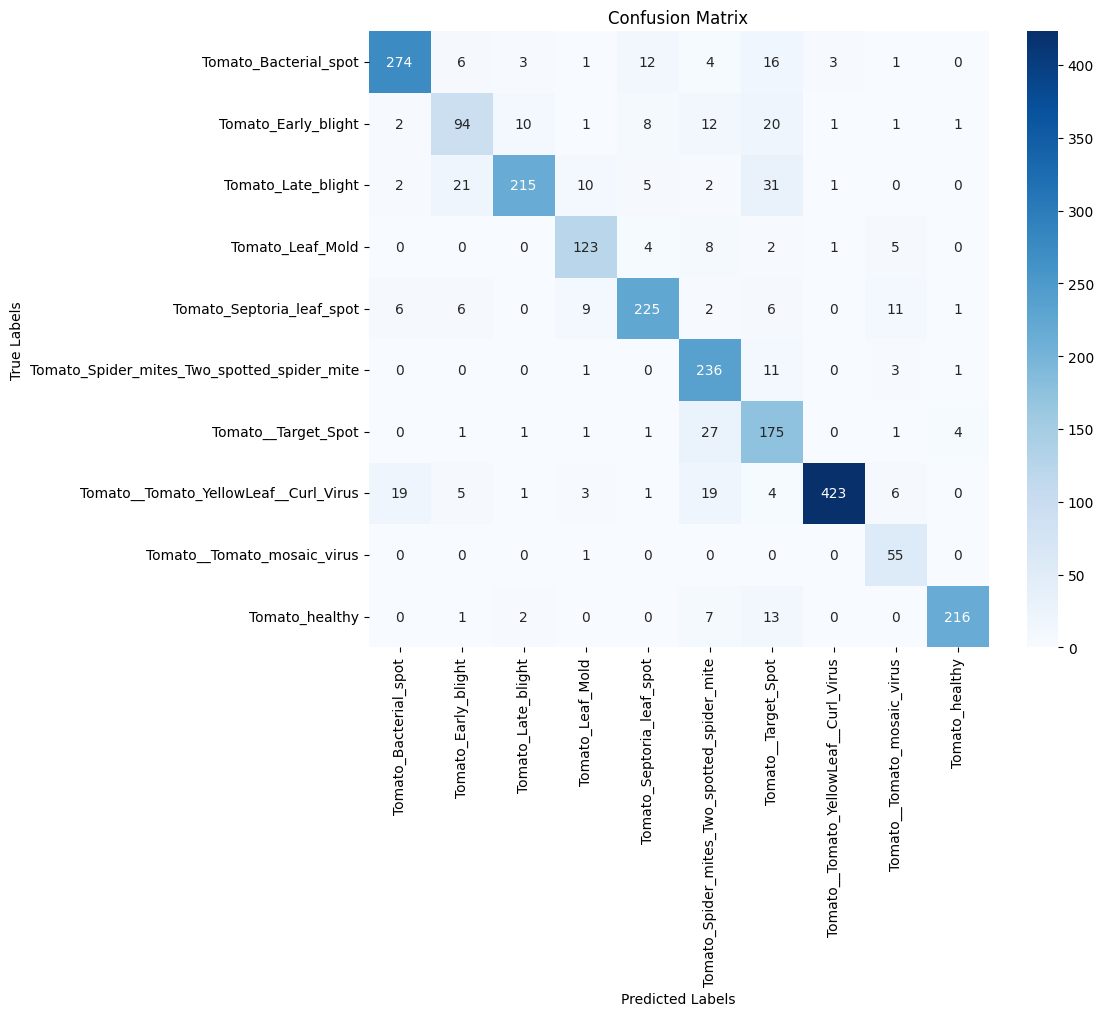

In [ ]:
y_predict = final_model.predict(test_gen)
y_predict = np.argmax(y_predict, axis=1)

cm = confusion_matrix(test_gen.classes, y_predict)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_keys, yticklabels=class_keys)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Classification Report**

In [ ]:
print(classification_report(test_gen.classes, y_predict, target_names=class_keys))

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.90      0.86      0.88       320
                        Tomato_Early_blight       0.70      0.63      0.66       150
                         Tomato_Late_blight       0.93      0.75      0.83       287
                           Tomato_Leaf_Mold       0.82      0.86      0.84       143
                  Tomato_Septoria_leaf_spot       0.88      0.85      0.86       266
Tomato_Spider_mites_Two_spotted_spider_mite       0.74      0.94      0.83       252
                        Tomato__Target_Spot       0.63      0.83      0.72       211
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.99      0.88      0.93       481
                Tomato__Tomato_mosaic_virus       0.66      0.98      0.79        56
                             Tomato_healthy       0.97      0.90      0.94       239

                                   accuracy                    